In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from xgboost import XGBClassifier

In [2]:
def model_metrics(model, X, y):

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # standardized scaling
    std = StandardScaler()
    std.fit(X_train.values)

    X_train_scaled = std.transform(X_train.values)
    X_test_scaled = std.transform(X_test.values)
    
    # fit model
    model.fit(X_train_scaled,y_train)
    
    # confusion matrix
    model_confusion = confusion_matrix(y_test, model.predict(X_test_scaled))
    plt.figure(dpi=100)
    sns.heatmap(model_confusion, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d',
                xticklabels=['legit', 'fraud'],
                yticklabels=['legit', 'fraud'])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(str(model) + ' Fraud Prediction Matrix')
    plt.savefig(str(model) + '_confusion_matrix.png', transparent=True, bbox_inches='tight')
    plt.show();
    
    # precision-recall curve
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:,1] )

    plt.figure(dpi=100)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Probability Cutoff Threshold')
    plt.ylabel('Score')
    plt.title(str(model) + ' Precision and Recall Curves')
    plt.savefig(str(model) + '_precision_recall_curves.png', transparent=True, bbox_inches='tight')
    plt.show();
    
    # roc curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])

    plt.figure(dpi=100)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Predicting Fraud with ' + str(model))
    plt.savefig(str(model) + '_roc_curve.png', transparent=True, bbox_inches='tight')
    plt.show();
    
    # scores
    print(str(model) + ' Scores\n')
    
    print('Accuracy:      ', model.score(X_test_scaled,y_test))

    y_predict = model.predict(X_test_scaled)

    print('Precision:     ', precision_score(y_test, y_predict))
    print('Recall:        ', recall_score(y_test, y_predict))
    print('F1:            ', f1_score(y_test, y_predict))

    y_prob_pred_test = model.predict_proba(X_test_scaled)[:,1].astype(np.float64)

    print('Log Loss:      ', log_loss(y_test,y_prob_pred_test))
    print('ROC AUC:       ', roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
    

In [3]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='Oranges_r')

    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('feature_importance.png', transparent=True, bbox_inches='tight')
    plt.show();

In [4]:
default_df = pd.read_csv('../01_data_collection/cc_fraud/card_transdata.csv')

In [5]:
default_df.shape

(1000000, 8)

In [6]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [7]:
default_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [8]:
default_df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


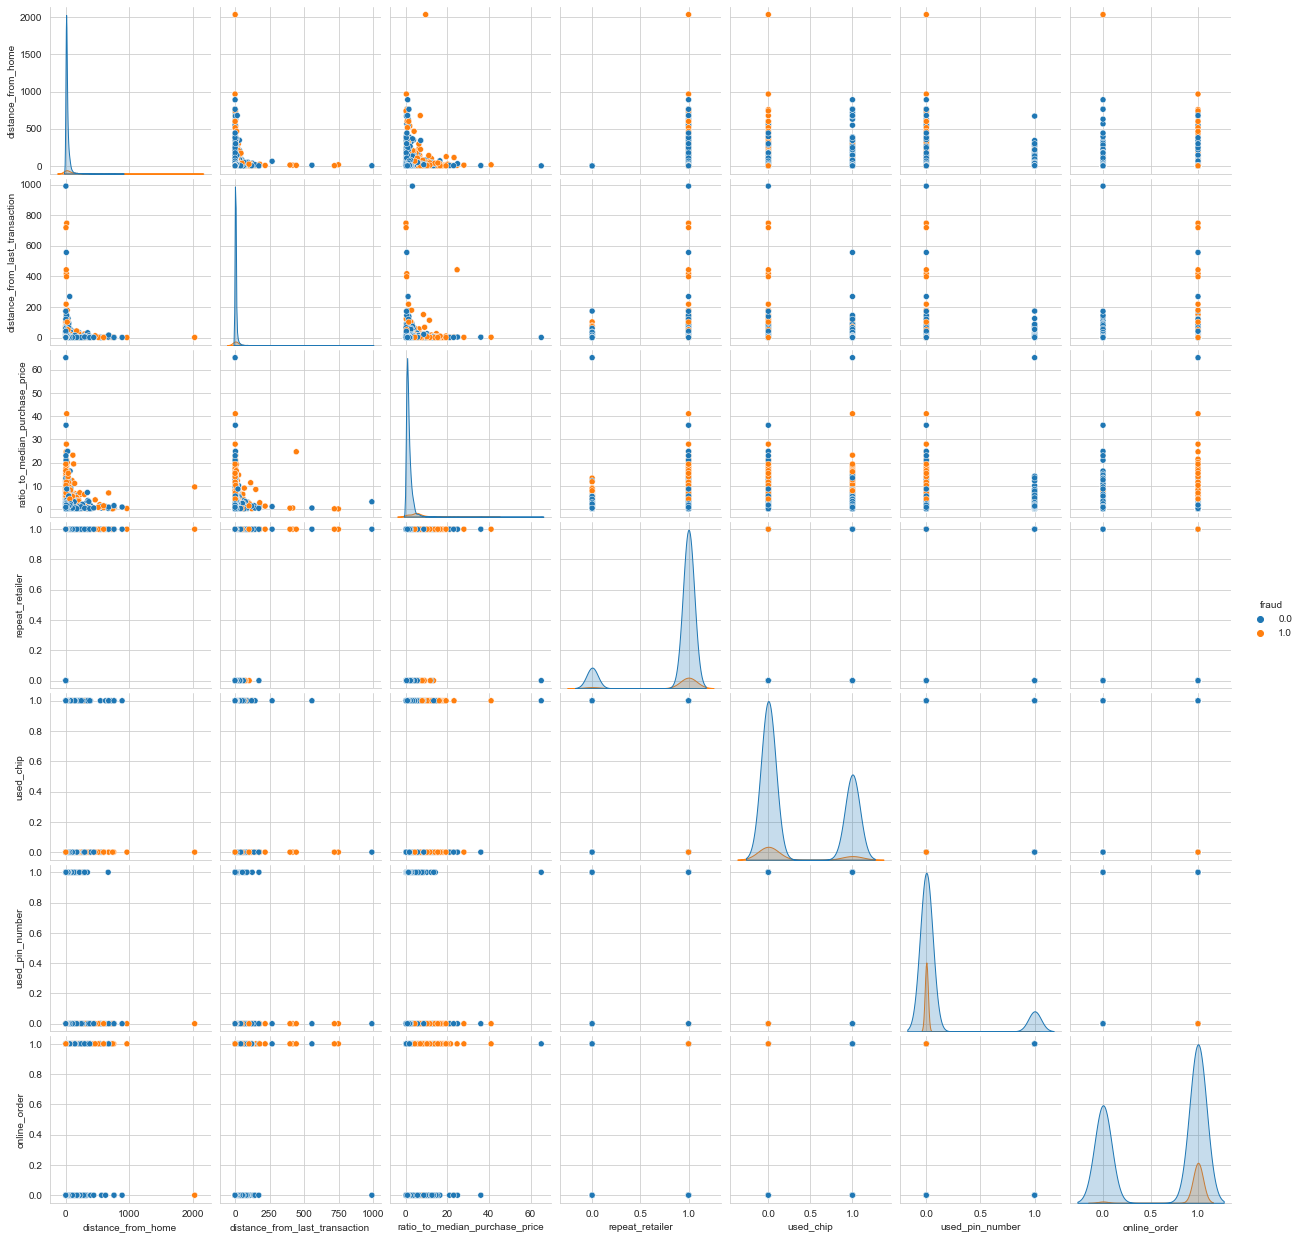

In [9]:
sample_df = default_df[0:5000]
sns.pairplot(sample_df, hue='fraud');

In [10]:
default_df['fraud'].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


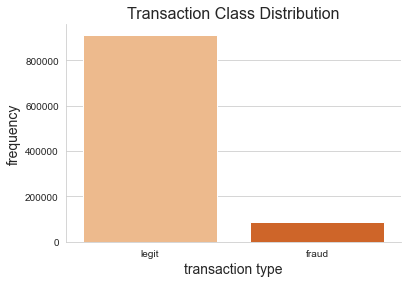

In [11]:
sns.countplot(default_df['fraud'], palette='Oranges' )
labels = ['legit', 'fraud']
plt.title('Transaction Class Distribution',fontsize = 16)
plt.xticks(range(2), labels) 
plt.xlabel('transaction type', fontsize =14)
plt.ylabel('frequency', fontsize = 14)
sns.despine()
plt.savefig('target_class_distribution.png')
plt.show();

In [12]:
X = default_df.drop(columns=['fraud'])
y = default_df['fraud']

In [13]:
X.shape

(1000000, 7)

In [14]:
y.shape

(1000000,)

In [15]:
default_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [16]:
default_df.shape

(1000000, 8)

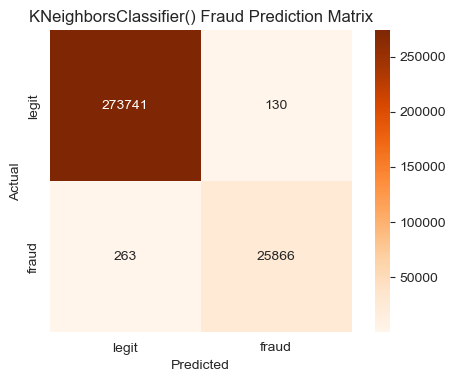

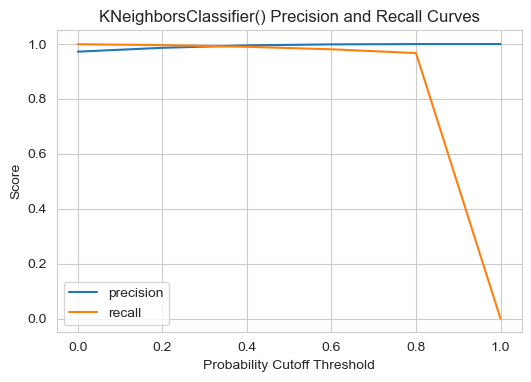

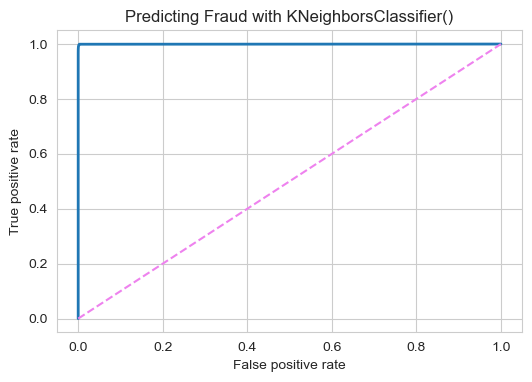

KNeighborsClassifier() Scores

Accuracy:       0.99869
Precision:      0.9949992306508694
Recall:         0.9899345554747598
F1:             0.9924604316546762
Log Loss:       0.005157619651169548
ROC AUC:        0.9996511820017853


In [17]:
knn = KNeighborsClassifier()
model_metrics(knn, X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
std = StandardScaler()
std.fit(X_train.values)

X_train_scaled = std.transform(X_train.values)
X_test_scaled = std.transform(X_test.values)

In [19]:
knn_precision = precision_score(y_test, knn.predict(X_test_scaled))
knn_recall = recall_score(y_test, knn.predict(X_test_scaled))
knn_f1 = f1_score(y_test, knn.predict(X_test_scaled))
knn_roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:,1])

In [20]:
print(knn_precision)
print(knn_recall)
print(knn_f1)
print(knn_roc_auc)

0.9949992306508694
0.9899345554747598
0.9924604316546762
0.9996511820017853


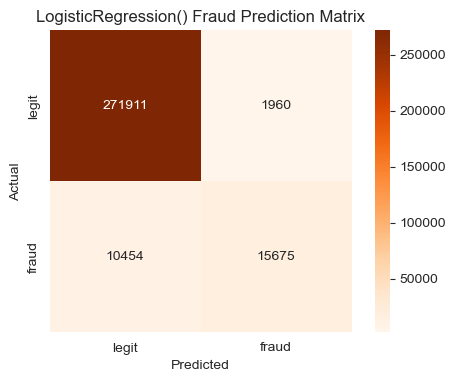

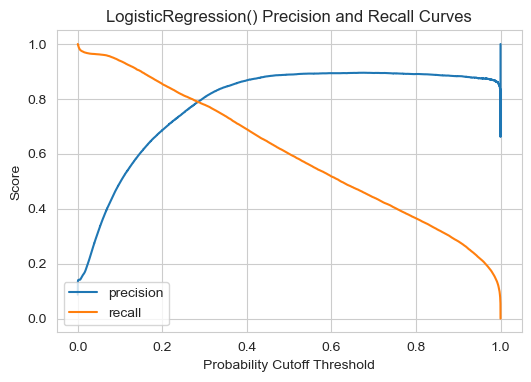

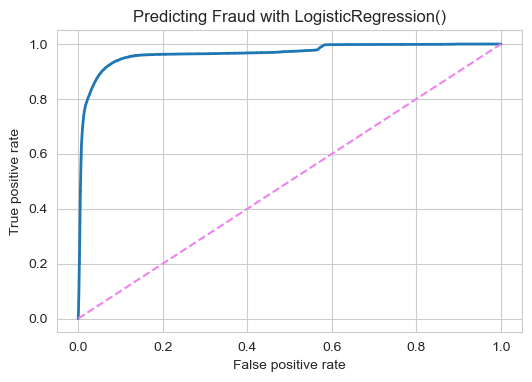

LogisticRegression() Scores

Accuracy:       0.95862
Precision:      0.8888573858803516
Recall:         0.5999081480347507
F1:             0.7163421990677269
Log Loss:       0.1346321733206216
ROC AUC:        0.9663789044916972


In [21]:
logreg = LogisticRegression()
model_metrics(logreg, X, y)

In [22]:
logisticregression_precision = precision_score(y_test, logreg.predict(X_test_scaled))
logisticregression_recall = recall_score(y_test, logreg.predict(X_test_scaled))
logisticregression_f1 = f1_score(y_test, logreg.predict(X_test_scaled))
logisticregression_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1])

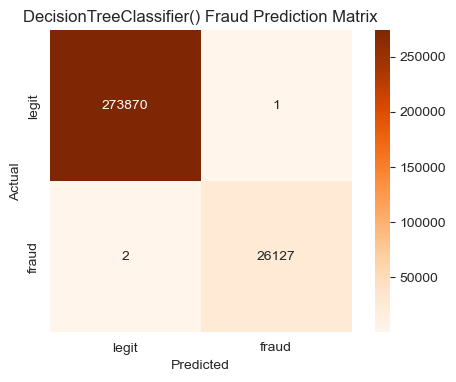

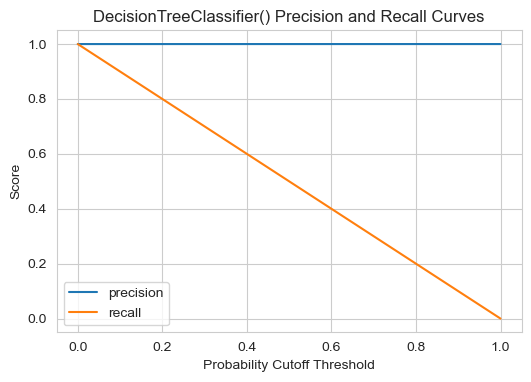

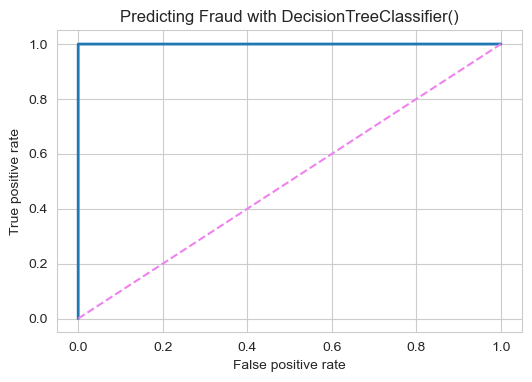

DecisionTreeClassifier() Scores

Accuracy:       0.99999
Precision:      0.9999617268830373
Recall:         0.9999234566956255
F1:             0.9999425914231586
Log Loss:       0.0003453904292748733
ROC AUC:        0.9999599026707605


In [23]:
decisiontree = DecisionTreeClassifier()
model_metrics(decisiontree, X, y)

In [24]:
decisiontree_precision = precision_score(y_test, decisiontree.predict(X_test_scaled))
decisiontree_recall = recall_score(y_test, decisiontree.predict(X_test_scaled))
decisiontree_f1 = f1_score(y_test, decisiontree.predict(X_test_scaled))
decisiontree_roc_auc = roc_auc_score(y_test, decisiontree.predict_proba(X_test_scaled)[:,1])

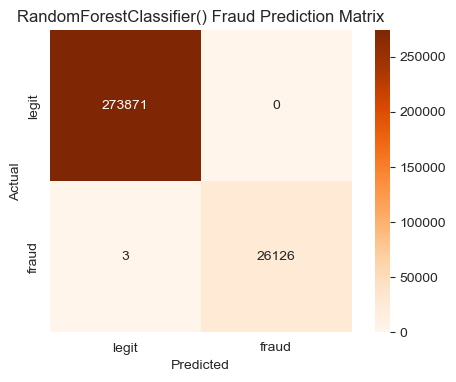

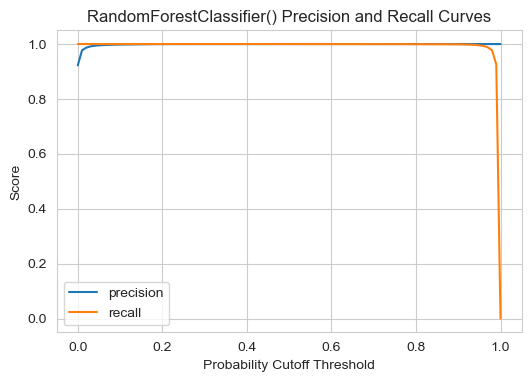

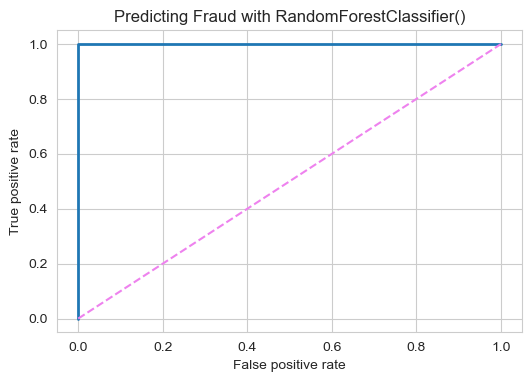

RandomForestClassifier() Scores

Accuracy:       0.99999
Precision:      1.0
Recall:         0.9998851850434384
F1:             0.9999425892259115
Log Loss:       0.0002809193521160587
ROC AUC:        1.0


In [25]:
randomforest = RandomForestClassifier()
model_metrics(randomforest, X, y)

In [26]:
randomforest_precision = precision_score(y_test, randomforest.predict(X_test_scaled))
randomforest_recall = recall_score(y_test, randomforest.predict(X_test_scaled))
randomforest_f1 = f1_score(y_test, randomforest.predict(X_test_scaled))
randomforest_roc_auc = roc_auc_score(y_test, randomforest.predict_proba(X_test_scaled)[:,1])

In [27]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.5)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

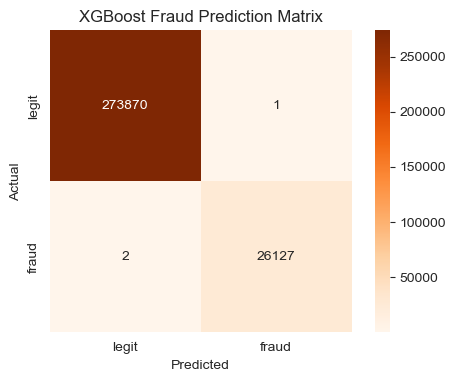

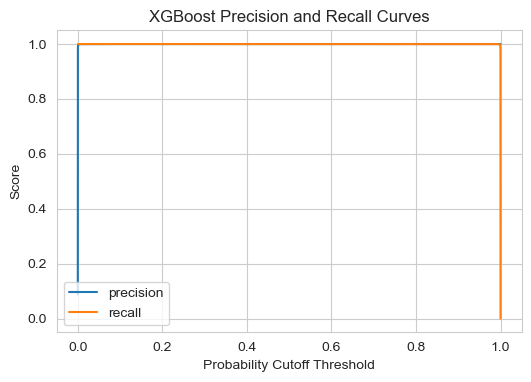

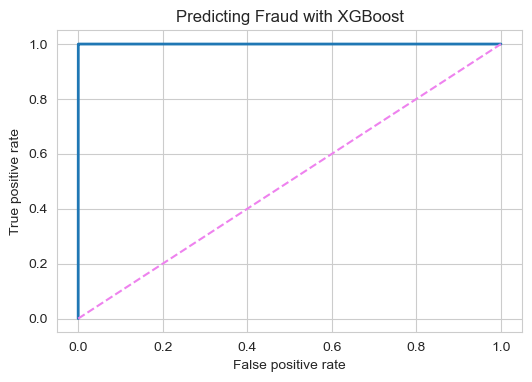

XGBoost Scores

Accuracy:       0.99999
Precision:      0.9999617268830373
Recall:         0.9999234566956255
F1:             0.9999425914231586
Log Loss:       7.685153710740925e-05
ROC AUC:        0.9999999652039048


In [36]:
xgb_confusion = confusion_matrix(y_test, xgb.predict(X_test_scaled))
plt.figure(dpi=100)
sns.heatmap(xgb_confusion, cmap=plt.cm.Oranges, annot=True, square=True, fmt='d',
            xticklabels=['legit', 'fraud'],
            yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Fraud Prediction Matrix')
plt.savefig('xgboost_confusion_matrix.png')
plt.show();
    
# precision-recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Probability Cutoff Threshold')
plt.ylabel('Score')
plt.title('XGBoost Precision and Recall Curves')
plt.savefig('xgboost_precision_recall_curves.png')
plt.show();
    
# roc curve
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Predicting Fraud with XGBoost')
plt.savefig('xgboost_roc_curve.png')
plt.show();
    
print('XGBoost Scores\n')

print('Accuracy:      ', xgb.score(X_test_scaled,y_test))

y_predict = xgb.predict(X_test_scaled)

print('Precision:     ', precision_score(y_test, y_predict))
print('Recall:        ', recall_score(y_test, y_predict))
print('F1:            ', f1_score(y_test, y_predict))

y_prob_pred_test = xgb.predict_proba(X_test_scaled)[:,1].astype(np.float64)

print('Log Loss:      ', log_loss(y_test,y_prob_pred_test))
print('ROC AUC:       ', roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:,1]))

In [29]:
xgboost_precision = precision_score(y_test, xgb.predict(X_test_scaled))
xgboost_recall = recall_score(y_test, xgb.predict(X_test_scaled))
xgboost_f1 = f1_score(y_test, xgb.predict(X_test_scaled))
xgboost_roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:,1])

In [30]:
model_name = ['kNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
scoring_metric = ['precision', 'recall', 'f1', 'roc_auc']
model_collection = []

for model in model_name:
    for obj in scoring_metric:
        entry = {'Model': model, 'Scoring Metric': obj, 'Score': round(eval(model.replace(' ','').lower()+'_'+obj),2)}
        model_collection.append(entry)

In [31]:
model_metrics = pd.DataFrame(model_collection)
model_metrics

,Model,Scoring Metric,Score
0,kNN,precision,0.99
1,kNN,recall,0.99
2,kNN,f1,0.99
3,kNN,roc_auc,1.00
4,Logistic Regression,precision,0.89
5,Logistic Regression,recall,0.60
6,Logistic Regression,f1,0.72
7,Logistic Regression,roc_auc,0.97
8,Decision Tree,precision,1.00
9,Decision Tree,recall,1.00


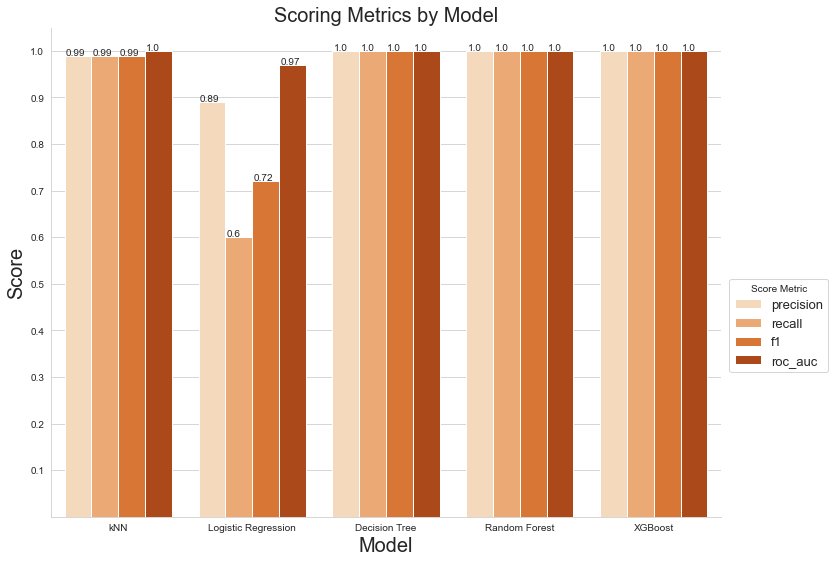

In [33]:
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_metrics,hue='Scoring Metric',palette='Oranges')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.0,1.05])
plt.yticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1.00])
plt.xlabel('Model', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Scoring Metrics by Model',fontsize=20)
sns.despine()
plt.savefig('modelbarplot.png',transparent=True, bbox_inches='tight')
plt.show();


In [34]:
## AND THE WINNER IS: DecisionTreeClassifier()

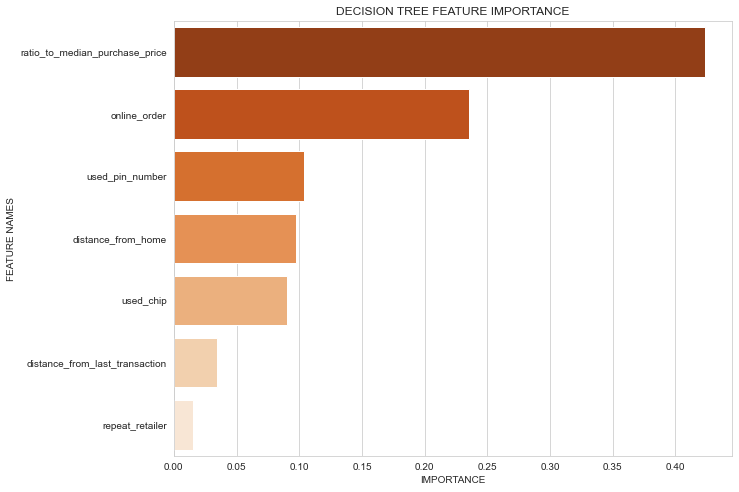

In [35]:
# plot decision tree feature importance
plot_feature_importance(decisiontree.feature_importances_,X_train.columns,'DECISION TREE')

In [37]:
# decision tree gridsearch cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

search_space = {'max_leaf_nodes': list(range(2,100)), 'min_samples_split':[2, 3, 4]}

decisiontree_gridsearch = GridSearchCV(estimator=decisiontree, param_grid=search_space,
                                       cv=kfold, n_jobs= -1, scoring='roc_auc', verbose=1)

decisiontree_gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=1)

In [38]:
print("Best estimator: ", decisiontree_gridsearch.best_estimator_)
print("Best score: ", decisiontree_gridsearch.best_score_)

Best estimator:  DecisionTreeClassifier(max_leaf_nodes=39, min_samples_split=3)
Best score:  0.9999177513037534


In [39]:
# instantiate DecisionTreeClassifier and fit (best parameters)
decisiontree = DecisionTreeClassifier(max_leaf_nodes=46, min_samples_split=3)
decisiontree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_leaf_nodes=46, min_samples_split=3)

In [40]:
print('Decision Tree Scores\n')

print('Accuracy:      ', decisiontree.score(X_test_scaled,y_test))

y_predict = decisiontree.predict(X_test_scaled)

print('Precision:     ', precision_score(y_test, y_predict))
print('Recall:        ', recall_score(y_test, y_predict))
print('F1:            ', f1_score(y_test, y_predict))

y_prob_pred_test = decisiontree.predict_proba(X_test_scaled)[:,1].astype(np.float64)

print('Log Loss:      ', log_loss(y_test,y_prob_pred_test))
print('ROC AUC:       ', roc_auc_score(y_test, decisiontree.predict_proba(X_test_scaled)[:,1]))

Decision Tree Scores

Accuracy:       0.99999
Precision:      0.9999617268830373
Recall:         0.9999234566956255
F1:             0.9999425914231586
Log Loss:       0.0003453904292748733
ROC AUC:        0.9999599026707605


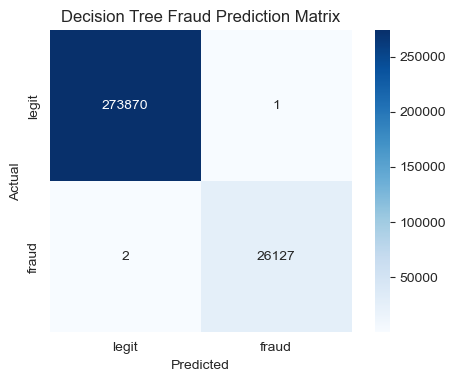

In [41]:
# decsion tree confusion matrix
decisiontree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test_scaled))
plt.figure(dpi=100)
sns.heatmap(decisiontree_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Fraud Prediction Matrix')
plt.show();